In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd


# Define the neural network architecture
class ParallelNN(nn.Module):
    def __init__(self, input1_size, hidden_size, num_classes):
        super(ParallelNN, self).__init__()

        # Define the first pipeline
        self.pipeline1 = nn.Sequential(
            nn.Linear(input1_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
        )

        # Define the final classification layer
        self.classification = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x1):
        out1 = self.pipeline1(x1)

        # Apply the final classification layer
        final_out = self.classification(out1)
        return final_out

# Define the input sizes, hidden size, and number of classes
#input1_size = 10  # Change this to match the number of features in your first dataset
#input2_size = 8   # Change this to match the number of features in your second dataset
#hidden_size = 64
#num_classes = 3   # Change this to match the number of classes in your classification task

# Initialize the model
#model = ParallelNN(input1_size, input2_size, hidden_size, num_classes)

# Define your loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)


In [2]:
# Load the data from a CSV file
NMR_csv_name = '../data/PD_Serum_Metabolomics_Final_NMR.csv'
MS_csv_name = '../data/preprocessed_data_PD.csv'

NMR_data = pd.read_csv(NMR_csv_name)
MS_data = pd.read_csv(MS_csv_name)

# Labels are first column of MS data
# Remove 305h row from MS data, because it is missing from NMR data
data1 = torch.tensor(NMR_data.values, dtype=torch.float32)
data2 = torch.tensor(MS_data.drop(index=305).iloc[:, 1:].values, dtype=torch.float32)
labels = torch.tensor(MS_data.drop(index=305).iloc[:, 0].values, dtype=torch.long)

# Normalize the data
row_normalization = True
if row_normalization:
    # Divide each row by its sum
    # data1 = data1 / data1.sum(dim=1, keepdim=True)
    # data2 = data2 / data2.sum(dim=1, keepdim=True)
    data1 = (data1 - data1.mean(dim=1, keepdim=True)) / data1.std(dim=1, keepdim=True)
    data2 = (data2 - data2.mean(dim=1, keepdim=True)) / data2.std(dim=1, keepdim=True)
data1 = (data1 - data1.mean(dim=0, keepdim=True)) / data1.std(dim=0, keepdim=True)
data2 = (data2 - data2.mean(dim=0, keepdim=True)) / data2.std(dim=0, keepdim=True)

# Concatenate the data
data = torch.cat((data1, data2), dim=1)

# Define model, loss function, and optimizer
model = ParallelNN(input1_size=data.shape[1], hidden_size=32, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
k_folds = 5

# Prepare data loaders
dataset = TensorDataset(data, labels)
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=1000)
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

# Training loop
def train(model, dataloader, criterion, optimizer, best_loss):
    pbar = tqdm(dataloader)
    correct = 0
    running_loss = 0
    

    for (data1, labels) in pbar:
        model.train()


        optimizer.zero_grad()
        outputs = model(data1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * data1.size(0)

        loss.backward()
        optimizer.step()

        # correct += (outputs.argmax(dim=1) == labels).float().sum()
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        accuracy = correct / 1000 # Used in sampling

        
        # Validation loop
        val_loss = 0
        val_accuracy = 0
        model.eval()

        with torch.no_grad():
            for (data1_v, labels_v) in val_loader:

                outputs = model(data1_v)
                loss = criterion(outputs, labels_v)
                val_loss += loss.item() * data1_v.size(0)
                val_accuracy += (outputs.argmax(dim=1) == labels_v).float().sum()
         
        pbar.set_description(f"Loss: {running_loss / 1000:.4f}, Accuracy: {accuracy:.4f}")

    val_loss /= 81
    val_accuracy /= 81 #len(val_set)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_one_pipeline_PD.pth')

    torch.save(model.state_dict(), 'latest_model_one_pipeline_PD.pth')

    return val_loss, val_accuracy, running_loss / 1000, accuracy
        

Epoch 1/30


Loss: 0.6668, Accuracy: 0.5690: 100%|██████████| 32/32 [00:02<00:00, 14.82it/s]


Validation Loss: 0.5628, Validation Accuracy: 0.4198
Epoch 2/30


Loss: 0.5404, Accuracy: 0.7370: 100%|██████████| 32/32 [00:01<00:00, 21.75it/s]


Validation Loss: 0.6561, Validation Accuracy: 0.5062
Epoch 3/30


Loss: 0.4523, Accuracy: 0.7900: 100%|██████████| 32/32 [00:01<00:00, 20.59it/s]


Validation Loss: 0.5289, Validation Accuracy: 0.4938
Epoch 4/30


Loss: 0.3902, Accuracy: 0.8320: 100%|██████████| 32/32 [00:01<00:00, 22.60it/s]


Validation Loss: 0.6418, Validation Accuracy: 0.4938
Epoch 5/30


Loss: 0.3680, Accuracy: 0.8360: 100%|██████████| 32/32 [00:01<00:00, 20.99it/s]


Validation Loss: 0.8420, Validation Accuracy: 0.5062
Epoch 6/30


Loss: 0.3203, Accuracy: 0.8570: 100%|██████████| 32/32 [00:01<00:00, 20.99it/s]


Validation Loss: 0.5639, Validation Accuracy: 0.5926
Epoch 7/30


Loss: 0.2429, Accuracy: 0.8990: 100%|██████████| 32/32 [00:01<00:00, 21.59it/s]


Validation Loss: 0.6242, Validation Accuracy: 0.5679
Epoch 8/30


Loss: 0.2304, Accuracy: 0.9010: 100%|██████████| 32/32 [00:01<00:00, 21.92it/s]


Validation Loss: 0.6529, Validation Accuracy: 0.5926
Epoch 9/30


Loss: 0.1876, Accuracy: 0.9190: 100%|██████████| 32/32 [00:01<00:00, 21.78it/s]


Validation Loss: 0.6000, Validation Accuracy: 0.5432
Epoch 10/30


Loss: 0.1586, Accuracy: 0.9500: 100%|██████████| 32/32 [00:01<00:00, 21.14it/s]


Validation Loss: 0.6434, Validation Accuracy: 0.5679
Epoch 11/30


Loss: 0.1311, Accuracy: 0.9510: 100%|██████████| 32/32 [00:01<00:00, 19.87it/s]


Validation Loss: 0.7088, Validation Accuracy: 0.6049
Epoch 12/30


Loss: 0.1338, Accuracy: 0.9510: 100%|██████████| 32/32 [00:01<00:00, 20.43it/s]


Validation Loss: 0.6486, Validation Accuracy: 0.5556
Epoch 13/30


Loss: 0.1359, Accuracy: 0.9440: 100%|██████████| 32/32 [00:01<00:00, 20.32it/s]


Validation Loss: 0.7183, Validation Accuracy: 0.5556
Epoch 14/30


Loss: 0.1576, Accuracy: 0.9440: 100%|██████████| 32/32 [00:01<00:00, 21.48it/s]


Validation Loss: 0.6345, Validation Accuracy: 0.5802
Epoch 15/30


Loss: 0.1459, Accuracy: 0.9450: 100%|██████████| 32/32 [00:01<00:00, 22.05it/s]


Validation Loss: 0.6535, Validation Accuracy: 0.5926
Epoch 16/30


Loss: 0.1401, Accuracy: 0.9480: 100%|██████████| 32/32 [00:01<00:00, 22.13it/s]


Validation Loss: 0.6658, Validation Accuracy: 0.5802
Epoch 17/30


Loss: 0.1518, Accuracy: 0.9370: 100%|██████████| 32/32 [00:01<00:00, 22.12it/s]


Validation Loss: 0.6615, Validation Accuracy: 0.5556
Epoch 18/30


Loss: 0.1257, Accuracy: 0.9500: 100%|██████████| 32/32 [00:01<00:00, 22.21it/s]


Validation Loss: 0.6469, Validation Accuracy: 0.5802
Epoch 19/30


Loss: 0.1368, Accuracy: 0.9480: 100%|██████████| 32/32 [00:01<00:00, 22.03it/s]


Validation Loss: 0.6694, Validation Accuracy: 0.5926
Epoch 20/30


Loss: 0.1556, Accuracy: 0.9350: 100%|██████████| 32/32 [00:01<00:00, 21.73it/s]


Validation Loss: 0.7102, Validation Accuracy: 0.5926
Epoch 21/30


Loss: 0.1337, Accuracy: 0.9460: 100%|██████████| 32/32 [00:01<00:00, 22.04it/s]


Validation Loss: 0.6812, Validation Accuracy: 0.5802
Epoch 22/30


Loss: 0.1507, Accuracy: 0.9370: 100%|██████████| 32/32 [00:01<00:00, 22.46it/s]


Validation Loss: 0.8200, Validation Accuracy: 0.5556
Epoch 23/30


Loss: 0.1490, Accuracy: 0.9350: 100%|██████████| 32/32 [00:01<00:00, 18.30it/s]


Validation Loss: 0.6835, Validation Accuracy: 0.5926
Epoch 24/30


Loss: 0.1410, Accuracy: 0.9420: 100%|██████████| 32/32 [00:01<00:00, 21.36it/s]


Validation Loss: 0.7223, Validation Accuracy: 0.5802
Epoch 25/30


Loss: 0.1311, Accuracy: 0.9520: 100%|██████████| 32/32 [00:01<00:00, 21.30it/s]


Validation Loss: 0.6461, Validation Accuracy: 0.5802
Epoch 26/30


Loss: 0.1337, Accuracy: 0.9420: 100%|██████████| 32/32 [00:01<00:00, 22.20it/s]


Validation Loss: 0.6801, Validation Accuracy: 0.5802
Epoch 27/30


Loss: 0.1435, Accuracy: 0.9440: 100%|██████████| 32/32 [00:01<00:00, 21.93it/s]


Validation Loss: 0.6784, Validation Accuracy: 0.5926
Epoch 28/30


Loss: 0.1456, Accuracy: 0.9470: 100%|██████████| 32/32 [00:01<00:00, 20.93it/s]


Validation Loss: 0.6693, Validation Accuracy: 0.6049
Epoch 29/30


Loss: 0.1557, Accuracy: 0.9350: 100%|██████████| 32/32 [00:01<00:00, 22.17it/s]


Validation Loss: 0.6604, Validation Accuracy: 0.5556
Epoch 30/30


Loss: 0.1325, Accuracy: 0.9430: 100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


Validation Loss: 0.6452, Validation Accuracy: 0.5679
Finished training
Best cutoff threshold:  0.26306346


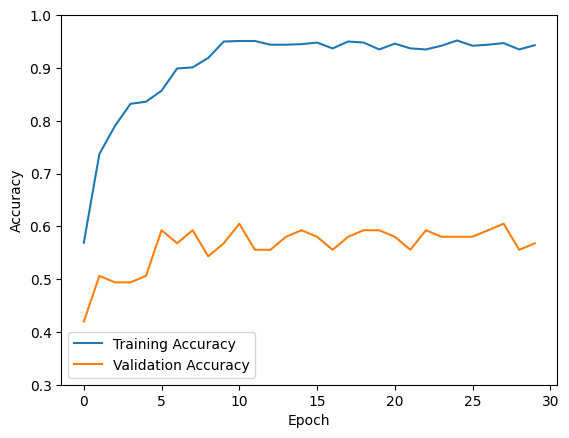

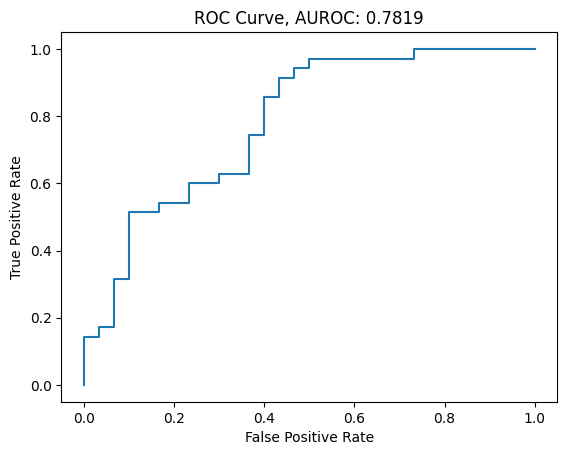

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Main function
def main():
    num_epochs = 30

    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        val_loss, val_accuracy, loss, accuracy = train(model, train_loader, criterion, optimizer, best_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        scheduler.step()

        accuracy_list.append(accuracy)
        loss_list.append(loss)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)

    print("Finished training")

    binary_string = 'binary'
    row_norm_string = 'row_norm' if row_normalization else 'no_row_norm'

    # Plot the training and validation loss
    plt.figure()
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yticks([i/10 for i in range(0, 20, 2)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/loss_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    plt.clf()
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.yticks([i/10 for i in range(3, 11, 1)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/accuracy_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Load the model (best or latest)
    model.load_state_dict(torch.load('best_model_one_pipeline_PD.pth'))

    model.eval()
    y_pred = []
    y_true = []
    y_pred_prob = pd.DataFrame()

    with torch.no_grad():
        for (data1, labels) in val_loader:

            outputs = model(data1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).numpy())
            y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(f"../Results_one_PD/confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Plot ROC curve with thresholds from 0.1 to 0.9
    plt.clf()
    # Calculate the AUROC score
    fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_true), y_pred_prob[1])
    print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])))
    plt.savefig(f"../Results_one_PD/roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    


if __name__ == '__main__':
    main()